### Project: Capstone project
### Author: Davis Byrd
### Date: 7/3/2025

#### For my capstone project, I plan to build a deep learning model that can automatically detect and classify different types of workout exercises performed by individuals using a YOLO object detection framework. In addition to classifying exercises such as push-ups, squats, pull-ups, etc. The project will also incorporate a YOLO-based pose estimation model to automatically annotate keypoints on the body. These keypoints will be used to track motion and calculate joint angles, enabling accurate rep counting for exercises. This integration aims to demonstrate rep counting for push-ups as an example showcase.


### Import necessary modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os
import shutil
import random
from collections import defaultdict
from collections import Counter

from PIL import Image
import yaml
import torch

from ultralytics import YOLO


### Verify that program will utilize GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Source and destination folders

In [3]:

original_folder = "exercise_images"

cleaned_folder = "cleaned_exercise_images"


#### note:
- Original folder contains the dataset I obtained from Kaggle
- Dataset is officially called Workout/Exercise Images
- This dataset was created by Hasyim Abdillah
- It contains 22 classes of exercises
- it was curated using Youtube videos and google images

- Cleaned_folder will hold only the sequential frames extracted from the Youtube videos


### Create destination directory for the sequential images

In [ ]:
os.makedirs(cleaned_folder, exist_ok=True)

### Loop through each exercise folder to copy sequential images to new cleaned folder

In [ ]:
total_images = 0
total_sequential = 0

for exercise_name in os.listdir(original_folder):
    exercise_path = os.path.join(original_folder, exercise_name)

    if os.path.isdir(exercise_path):
        # Create corresponding subfolder in cleaned directory
        cleaned_exercise_path = os.path.join(cleaned_folder, exercise_name)
        os.makedirs(cleaned_exercise_path, exist_ok=True)

        for filename in os.listdir(exercise_path):

            if filename.lower().endswith(('.jpg')):
                total_images += 1

                # Skip non-sequential images (those containing '_g')
                if "_g" in filename.lower():
                    continue

                src = os.path.join(exercise_path, filename)
                dst = os.path.join(cleaned_exercise_path, filename)

                shutil.copy2(src, dst)  # Copy the sequential image
                total_sequential += 1

print(f"Total images in original dataset: {total_images}")
print(f"Total sequential images copied: {total_sequential}")
print(f"Cleaned dataset saved to: '{cleaned_folder}'")

#### Note:
- Extracting only the sequential images from dataset isn't required
- I decided to rely on these images only to optimize the training process

#### Advantages of using sequential images:
- Captures a full range of motion, allowing the model to learn the temporal progression and body positions for each exercise
- More consistency in environment like lighting, angle, distance, etc, helps the model generalize better during training
- Pose estimation benefits greatly from smooth transitions between frames. Random images won't provide this

### Determine if size of 480x360 specified in kaggle dataset used here is consistent

In [ ]:

max_width = 0
max_height = 0
max_file = ""

for root, dirs, files in os.walk(cleaned_folder):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            with Image.open(img_path) as img:
                width, height = img.size
                if width * height > max_width * max_height:
                    max_width = width
                    max_height = height
                    max_file = img_path

print(f"Max image size: {max_width}x{max_height} in file: {max_file}")

Max image size: 1920x1088 in file: cleaned_exercise_images\bench press\bench press_1000041.jpg


#### Note:
- Determining image size is important in training a model such as YOLO
- Ensuring all images share the same dimensions keeps the network’s convolutional and attention layers aligned and the detection grid consistent
- Inconsistent sizes can confuse feature extraction, misalign anchors or prediction grids, and degrade accuracy

#### Next:
- Now that it has been determined that image size is not consistent, I will need to resize images before training
- Before Training however, the cleaned dataset will be exported to Roboflow for further processing
- In Roboflow, I annotated 200 images per exercise class and added augmentation such as rotation, blur, and noise
- In addition to the augmentation of the images, the process yielded a total of 11,400 images to train on
- Although The YOLO11 model has a built-in resizing process, I went ahead and resized the images in Roboflow before exporting

### Load and verify class data in the data.yaml file from the exported roboflow_exercise_images dataset

In [6]:
with open('roboflow_exercise_images\data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']  # This is the ordered list
print(class_names)
print(f"Total classes: {len(class_names)}")

['barbell biceps curl', 'bench press', 'chest fly', 'deadlift', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'pull up', 'push up', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']
Total classes: 19


#### Note:
- data.yaml file is a configuration file that provides crucial information about your dataset for training object detection models, especially those in the YOLO format
- It acts as a guide for your training process, specifying where to find the data and what objects to look for
- File contains the path to both the train and validation sets in balanced folder

---------------------------------------------------------------------------------------------------------
- While using Roboflow for initial dataset creation and processing, I decided to remove 3 classes
- 2 of the classes were too similar to others that The model may struggle to distinguish between them
- The plank, decline bench press, and romanian deadlift were all removed
- Plank was removed because I wanted to only use exercises that involved motion
- Decline bench press was removed because it is too similar to the bench press class
- Romanian deadlift was removed because it is too similar to the deadlift class

### Make sure that the exported dataset from Roboflow is complete and contains all 19 labled classes

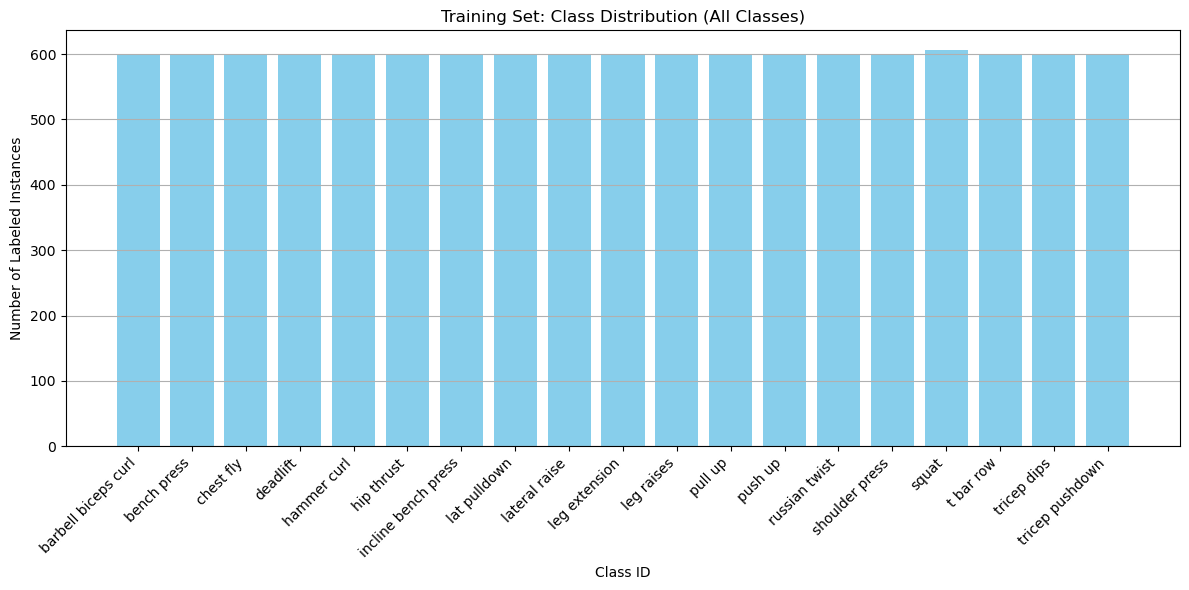

In [7]:
import os
from collections import Counter
import matplotlib.pyplot as plt

train_path = 'roboflow_exercise_images/train/labels'
num_classes = 19  # update this if you have more/fewer classes

# Count class instances
train_class_counts = Counter()

for file in os.listdir(train_path):
    with open(os.path.join(train_path, file), 'r') as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            train_class_counts[class_id] += 1

# Ensure all class IDs are included
all_class_ids = list(range(num_classes))
train_image_counts = [train_class_counts.get(cls_id, 0) for cls_id in all_class_ids]


# Plot
plt.figure(figsize=(12, 6))
plt.bar(all_class_ids, train_image_counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Labeled Instances')
plt.title('Training Set: Class Distribution (All Classes)')
plt.xticks(all_class_ids, class_names, rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Observation:
- The exported Roboflow dataset contains all the images in a single train set
- Roboflow correctly exported the training dataset
- Contains all 19 classes
- Each class has an equal and adequate number of images

### Perform a 80/20 train/validation split

In [ ]:

# Paths
base_path = 'roboflow_exercise_images'
original_images = os.path.join(base_path, 'train/images')
original_labels = os.path.join(base_path, 'train/labels')

new_train_img = os.path.join(base_path, 'balanced/train/images')
new_train_lbl = os.path.join(base_path, 'balanced/train/labels')
new_val_img = os.path.join(base_path, 'balanced/valid/images')
new_val_lbl = os.path.join(base_path, 'balanced/valid/labels')

# Create new directories
for path in [new_train_img, new_train_lbl, new_val_img, new_val_lbl]:
    os.makedirs(path, exist_ok=True)

# Group files by class
class_to_files = defaultdict(list)

for label_file in os.listdir(original_labels):
    with open(os.path.join(original_labels, label_file), 'r') as f:
        lines = f.readlines()
        if not lines:
            continue
        first_class = int(lines[0].split()[0])  # Assumes one class per image
        class_to_files[first_class].append(label_file)

# Split per class and copy files
val_split = 0.2  # 20% validation
for cls, files in class_to_files.items():
    random.shuffle(files)
    val_count = int(len(files) * val_split)

    val_files = files[:val_count]
    train_files = files[val_count:]

    for subset, subset_files in [('train', train_files), ('valid', val_files)]:
        img_dst = new_train_img if subset == 'train' else new_val_img
        lbl_dst = new_train_lbl if subset == 'train' else new_val_lbl

        for lbl_file in subset_files:
            img_file = lbl_file.replace('.txt', '.jpg')  # assumes .jpg images

            shutil.copy2(os.path.join(original_images, img_file), img_dst)
            shutil.copy2(os.path.join(original_labels, lbl_file), lbl_dst)

print("Dataset split complete. Balanced train/valid folders created.")

Dataset split complete. Balanced train/valid folders created.


#### Note:
- This splits the images into a balanced 80/20 train/validation set
- The set is then placed into a seperate folder named balanced
- This balanced folder contains the train and validation sets


### Check the balanced train set 

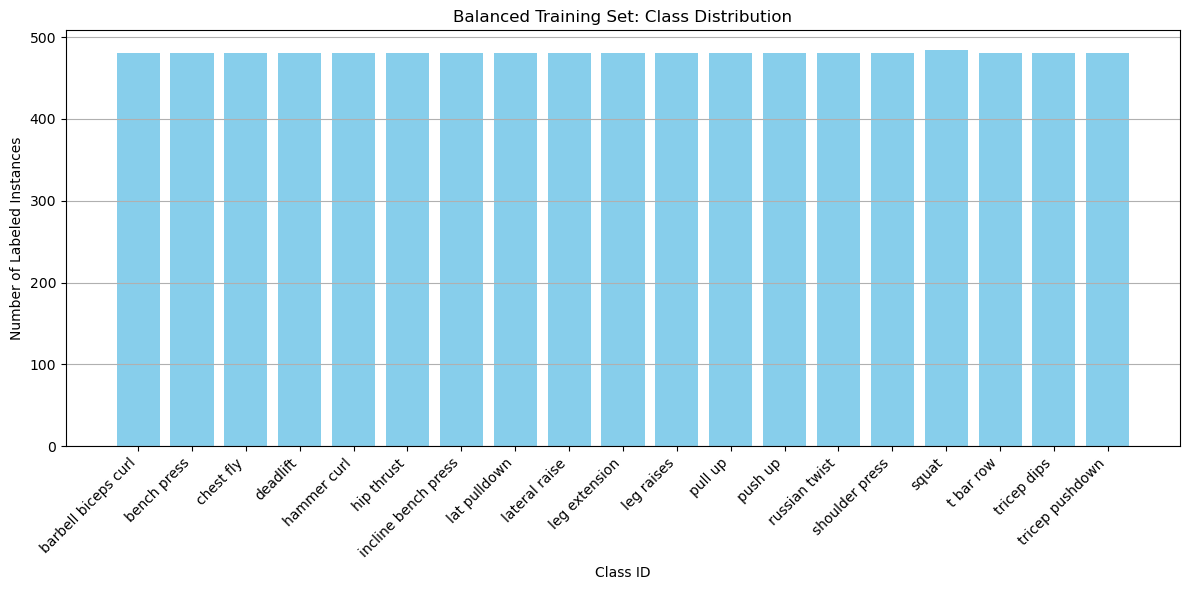

In [8]:


val_path = 'roboflow_exercise_images/balanced/train/labels'
num_classes = 19  # total number of classes in your project

# Count class instances
class_counts = Counter()

for file in os.listdir(val_path):
    with open(os.path.join(val_path, file), 'r') as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            class_counts[class_id] += 1

# Ensure all class IDs are present, even if count is 0
all_class_ids = list(range(num_classes))
image_counts = [class_counts.get(cls_id, 0) for cls_id in all_class_ids]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(all_class_ids, image_counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Labeled Instances')
plt.title('Balanced Training Set: Class Distribution')
plt.xticks(all_class_ids, class_names, rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Observation:
- As shown, the newly created training set is balanced across all classes
- This will allow the model to improves generalization after training
- Unbalanced Data Can Lead to Overfitting

### Check the balanced validation set

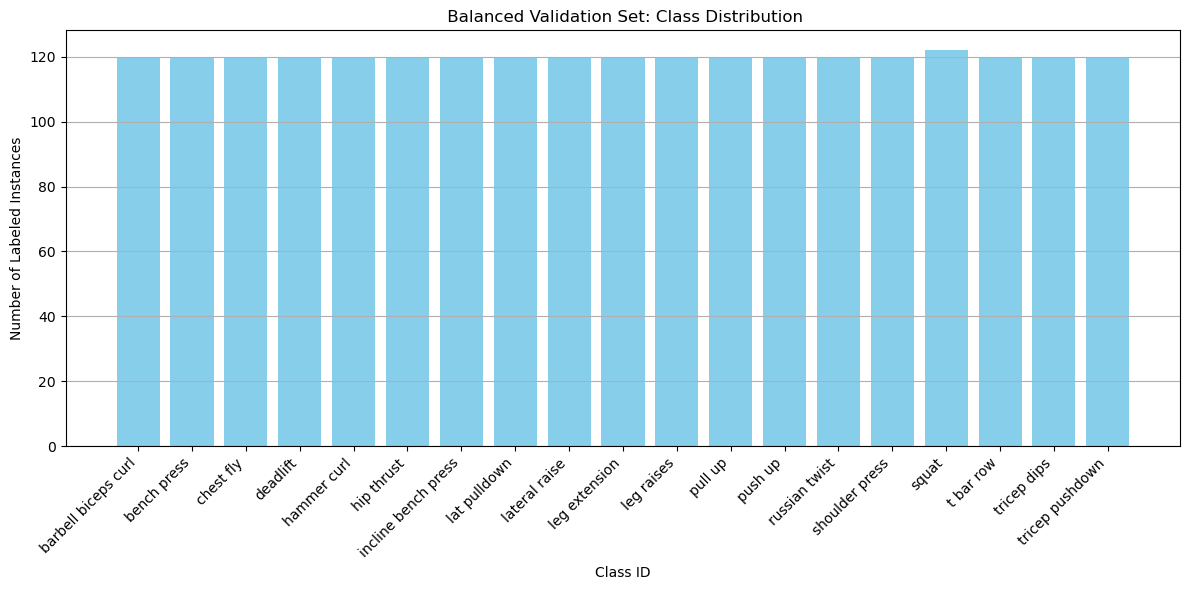

In [9]:

train_path = 'roboflow_exercise_images/balanced/valid/labels'
num_classes = 19  # update this if you have more/fewer classes

# Count class instances
train_class_counts = Counter()

for file in os.listdir(train_path):
    with open(os.path.join(train_path, file), 'r') as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            train_class_counts[class_id] += 1

# Ensure all class IDs are included
all_class_ids = list(range(num_classes))
train_image_counts = [train_class_counts.get(cls_id, 0) for cls_id in all_class_ids]


# Plot
plt.figure(figsize=(12, 6))
plt.bar(all_class_ids, train_image_counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Labeled Instances')
plt.title(' Balanced Validation Set: Class Distribution')
plt.xticks(all_class_ids, class_names, rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Observation:
- As shown, the newly created validation set is balanced across all classes
- This will allow the model to make better predictions
- The measure of how well a model is generalizing will be more accurately reflected by the validation set

### Specify the path to the folder containing the data.yaml file

In [3]:
data_path = 'roboflow_exercise_images\data.yaml'

In [9]:
model = YOLO("yolo11s.pt") 
print("YOLOv11 loaded successfully!")

YOLOv11 loaded successfully!


#### Start automated hyperparameter tuning

In [ ]:

results = model.tune(
    data=data_path,       
    epochs=20,            
    imgsz=640,
    iterations=10,        
    optimizer="Adam",
    device=str(device),  
    save=True,           
    plots=False,
    verbose=True,
    resume=False         
)

Tuner: Initialized Tuner instance with 'tune_dir=runs\detect\tune'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0}
Saved runs\detect\tune\tune_scatter_plots.png
Saved runs\detect\tune\tune_fitness.png

Tuner: 1/10 iterations complete  (2956.91s)
Tuner: Results saved to runs\detect\tune
Tuner: Best fitness=0.81044 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.96456, 'metrics/recall(B)': 0.9671, 'metrics/mAP50(B)': 0.98763, 'metrics/mAP50-95(B)': 0.79076, 'val/box_loss': 0.78819, 'val

### Load the best hyperparameter configuration 

In [17]:
with open("runs/detect/tune/best_hyperparameters.yaml", 'r') as f:
    best_config = yaml.safe_load(f)

### Start training the YOLO 11 model with configuration file from above

In [ ]:
model.train(
    data=data_path,
    epochs=100,
    imgsz=640,
    device=str(device),
    batch=16,
    patience=20,
    optimizer="Adam",
    save=True,
    plots=False,
    verbose=True,
    **best_config
)

New https://pypi.org/project/ultralytics/8.3.157 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.151  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=4.97567, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.48499, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=roboflow_exercise_images\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=2.0554, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.70805, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01352, hsv_s=0.85764, hsv_v=0.41613, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00835, lrf=0.01159, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.92632, mosaic=1.0, multi_scale=False, name=train11

train: Scanning F:\LSU_Fullstack_AI_Machine_Learning_Course\capstone_project\roboflow_exercise_images\balanced\train\labels.cache... 9120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9120/9120 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 159.264.0 MB/s, size: 37.5 KB)


val: Scanning F:\LSU_Fullstack_AI_Machine_Learning_Course\capstone_project\roboflow_exercise_images\balanced\valid\labels.cache... 2280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2280/2280 [00:00<?, ?it/s]


optimizer: Adam(lr=0.00835, momentum=0.92632) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00026), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train11
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.98G      1.107      3.078      2.557         29        640: 100%|██████████| 570/570 [02:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:21<00:00,  3.37it/s]


                   all       2280       2282      0.468      0.089     0.0243     0.0062

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.77G      1.062      2.667      2.432         36        640: 100%|██████████| 570/570 [02:06<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:18<00:00,  3.81it/s]


                   all       2280       2282       0.21      0.377      0.191     0.0858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.77G      1.013      2.428      2.355         39        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.05it/s]

                   all       2280       2282      0.363      0.438      0.329      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.77G     0.9744      2.235      2.283         35        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.551      0.503      0.533      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.77G     0.9421      2.073      2.224         42        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.414      0.553      0.499      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.77G     0.9213      1.975        2.2         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.504      0.585      0.592      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.77G     0.9061      1.862      2.173         35        640: 100%|██████████| 570/570 [02:04<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.04it/s]

                   all       2280       2282      0.646      0.628      0.693      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.77G     0.8875       1.79      2.148         44        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.632      0.638      0.694      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.77G     0.8723      1.696      2.115         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.667      0.622      0.696      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.77G     0.8616      1.635      2.101         38        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.769      0.748      0.836      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.77G     0.8552      1.579      2.088         38        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282       0.74      0.671      0.777       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.77G     0.8431      1.533      2.063         25        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.757       0.73      0.827      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.77G       0.83      1.484      2.049         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.05it/s]

                   all       2280       2282      0.765      0.741      0.833      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.77G     0.8196      1.449      2.038         30        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.804      0.811      0.889       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.77G     0.8063       1.39      2.021         32        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.08it/s]

                   all       2280       2282      0.821      0.802      0.879      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.77G     0.7973      1.377      2.006         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.799      0.754      0.847      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.77G      0.794      1.343      2.001         35        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282      0.832      0.847      0.921      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.77G     0.7794      1.295      1.982         38        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.857      0.842      0.924       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.77G     0.7702      1.268      1.963         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.862       0.85      0.928      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.77G     0.7689      1.232      1.962         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.869      0.851      0.937      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.77G     0.7596      1.209      1.954         40        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.892      0.887       0.95       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.77G     0.7435       1.17      1.923         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.876      0.845      0.931      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.77G     0.7369      1.136      1.918         30        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.886      0.888      0.946      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.77G     0.7378       1.13       1.92         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.883      0.881      0.951      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.77G     0.7216      1.093      1.895         40        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.895      0.909       0.96      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.77G     0.7196      1.077      1.897         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.06it/s]

                   all       2280       2282       0.92      0.918      0.971      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.77G     0.7151      1.066      1.889         27        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.875      0.879      0.951      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.77G     0.7029       1.03      1.872         28        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.935      0.913       0.97      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.77G     0.6974      1.027      1.863         36        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.943      0.944      0.982      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.77G     0.6907     0.9914      1.853         44        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.942      0.934      0.977       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.77G     0.6857      0.979      1.843         44        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.938      0.944       0.98      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.77G     0.6837     0.9714      1.836         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.04it/s]

                   all       2280       2282      0.962      0.961      0.987      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.77G     0.6679     0.9381       1.82         31        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.08it/s]

                   all       2280       2282      0.969      0.962      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.77G     0.6741     0.9297      1.826         42        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.962      0.963      0.986      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.77G     0.6611     0.9013      1.809         42        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.962      0.959      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.77G     0.6639     0.9148      1.817         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.963      0.961      0.988       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.77G     0.6567     0.8891      1.805         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.968      0.971      0.989      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.77G     0.6546     0.8809      1.805         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.965      0.969      0.989      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.77G     0.6476     0.8722      1.791         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282      0.962      0.968      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.77G      0.644     0.8557      1.789         34        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.971      0.975       0.99      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.77G     0.6372     0.8344      1.785         34        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.974      0.969      0.991      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.77G     0.6371     0.8278      1.776         49        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.976      0.981      0.991      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.77G      0.634     0.8204      1.772         39        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.979      0.976      0.992       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.77G     0.6243      0.816      1.763         32        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282       0.98      0.983      0.992      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.77G     0.6229     0.8022      1.757         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.981      0.981      0.992      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.77G     0.6118     0.7745      1.745         38        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.978      0.981      0.991      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.77G      0.611     0.7798      1.747         36        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.972      0.979       0.99      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.77G     0.6118     0.7741      1.745         39        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282       0.98       0.98      0.992      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.77G     0.6081     0.7697      1.744         29        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.986      0.981      0.993      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.77G     0.5991     0.7529      1.732         39        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282      0.983      0.982      0.992      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.77G      0.599     0.7429      1.732         35        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.985       0.99      0.994      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.77G     0.5852     0.7327      1.716         41        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.987      0.985      0.994      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.77G     0.5853      0.718       1.71         42        640: 100%|██████████| 570/570 [02:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.988      0.985      0.994      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.77G     0.5881     0.7253       1.72         30        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282      0.982      0.989      0.994      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.77G     0.5839     0.7094      1.708         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.986      0.985      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.77G     0.5789      0.701      1.702         36        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.991      0.991      0.994      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.77G     0.5757     0.6919      1.701         33        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.989      0.985      0.994      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.77G     0.5686     0.6859      1.685         29        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282       0.99      0.988      0.994      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.77G     0.5626     0.6785      1.683         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.989      0.989      0.994      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.77G     0.5678     0.6796      1.687         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282       0.99      0.987      0.994      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.77G     0.5594     0.6598      1.675         46        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.987      0.988      0.994       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.77G     0.5619     0.6594      1.677         36        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.07it/s]

                   all       2280       2282       0.99      0.983      0.994      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.77G     0.5536     0.6548      1.666         38        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.16it/s]

                   all       2280       2282      0.986      0.991      0.994      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.77G     0.5508     0.6425      1.668         40        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.992      0.988      0.995      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.77G     0.5464     0.6288      1.659         36        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.986      0.993      0.994      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.77G     0.5391     0.6224      1.652         39        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.987      0.992      0.994      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.77G     0.5412     0.6217      1.655         42        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.989      0.993      0.995      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.77G     0.5377       0.62      1.653         32        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.992      0.988      0.995      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.77G     0.5343     0.6067      1.651         33        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.994      0.988      0.995       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.77G     0.5302     0.5985      1.637         33        640: 100%|██████████| 570/570 [02:04<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.08it/s]

                   all       2280       2282      0.994      0.988      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.77G      0.529     0.5959      1.636         46        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.18it/s]

                   all       2280       2282      0.995      0.987      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.77G     0.5234     0.5917      1.632         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.11it/s]

                   all       2280       2282      0.993      0.991      0.995      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.77G     0.5202     0.5807      1.628         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.995      0.986      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.77G     0.5161     0.5814      1.624         35        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.996      0.987      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.77G     0.5107     0.5706       1.62         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.09it/s]

                   all       2280       2282      0.995      0.987      0.995      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.77G     0.5147      0.571      1.622         40        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.08it/s]

                   all       2280       2282      0.994      0.988      0.995      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.77G     0.5072     0.5587      1.617         30        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.14it/s]

                   all       2280       2282      0.996      0.989      0.995       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.77G     0.5042     0.5522       1.61         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.995      0.988      0.995      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.77G     0.4998     0.5433      1.599         38        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.993      0.991      0.995      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.77G     0.4981     0.5429      1.603         30        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.996       0.99      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.77G     0.4955      0.538      1.597         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.16it/s]

                   all       2280       2282      0.996      0.989      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.77G     0.4903     0.5321      1.588         32        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.994      0.992      0.995      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.77G     0.4842     0.5226      1.585         35        640: 100%|██████████| 570/570 [02:04<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.13it/s]

                   all       2280       2282      0.992      0.993      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.77G     0.4845     0.5237      1.583         45        640: 100%|██████████| 570/570 [02:04<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:18<00:00,  3.99it/s]

                   all       2280       2282      0.994       0.99      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.77G     0.4818     0.5187      1.578         32        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.10it/s]

                   all       2280       2282      0.994      0.991      0.995      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.77G      0.474     0.5048       1.57         37        640: 100%|██████████| 570/570 [02:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.12it/s]

                   all       2280       2282      0.994      0.991      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.77G     0.4789     0.5048      1.578         35        640: 100%|██████████| 570/570 [02:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.26it/s]

                   all       2280       2282       0.99      0.996      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.77G     0.4733     0.5006      1.575         37        640: 100%|██████████| 570/570 [01:59<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.22it/s]

                   all       2280       2282      0.989      0.997      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.77G     0.4649     0.4929      1.561         31        640: 100%|██████████| 570/570 [01:59<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.22it/s]

                   all       2280       2282      0.989      0.996      0.995       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.77G     0.4606     0.4905       1.56         33        640: 100%|██████████| 570/570 [01:59<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.22it/s]

                   all       2280       2282      0.989      0.997      0.995       0.86


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.77G     0.4007     0.3408      1.557         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:18<00:00,  3.82it/s]

                   all       2280       2282      0.991      0.996      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.77G      0.383     0.3182      1.531         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

                   all       2280       2282      0.992      0.996      0.995      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.77G      0.376     0.3133      1.516         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.25it/s]

                   all       2280       2282      0.993      0.996      0.995      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.77G     0.3623     0.3059       1.49         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.28it/s]

                   all       2280       2282      0.993      0.997      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.77G     0.3576     0.2955       1.48         17        640: 100%|██████████| 570/570 [01:59<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.21it/s]

                   all       2280       2282      0.993      0.997      0.995      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.77G     0.3495     0.2902      1.466         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.24it/s]

                   all       2280       2282      0.992      0.997      0.995      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.77G     0.3447     0.2853      1.455         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.24it/s]

                   all       2280       2282      0.992      0.997      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.77G     0.3398     0.2828       1.45         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:16<00:00,  4.26it/s]

                   all       2280       2282      0.991      0.998      0.995      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.77G     0.3348     0.2771      1.441         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.23it/s]

                   all       2280       2282      0.991      0.998      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.77G     0.3297     0.2755      1.432         16        640: 100%|██████████| 570/570 [01:59<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:17<00:00,  4.20it/s]

                   all       2280       2282      0.991      0.998      0.995      0.877



100 epochs completed in 4.043 hours.
Optimizer stripped from runs\detect\train11\weights\last.pt, 19.2MB
Optimizer stripped from runs\detect\train11\weights\best.pt, 19.2MB

Validating runs\detect\train11\weights\best.pt...
Ultralytics 8.3.151  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11s summary (fused): 100 layers, 9,420,153 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 72/72 [00:14<00:00,  4.84it/s]

                   all       2280       2282      0.992      0.998      0.995      0.877
   barbell biceps curl        120        120      0.995          1      0.995      0.915
           bench press        120        120      0.975          1      0.995      0.864
             chest fly        120        120      0.995          1      0.995      0.886
              deadlift        120        120      0.992      0.978      0.995      0.851
           hammer curl        120        120      0.995          1      0.995      0.885
            hip thrust        120        120      0.994          1      0.995      0.863
   incline bench press        120        120      0.996          1      0.995       0.87
          lat pulldown        120        120      0.995          1      0.995      0.877
         lateral raise        120        120       0.99          1      0.995      0.885
         leg extension        120        120      0.992      0.999      0.995      0.865
            leg raise

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000223CE63B0A0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

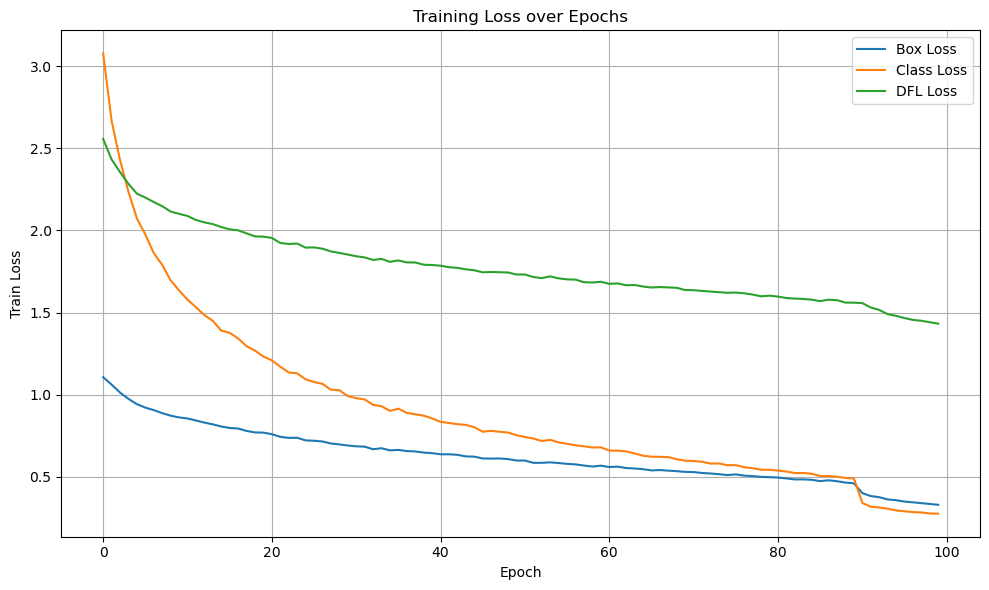

In [ ]:
results_path = "runs/detect/train11/results.csv" 
df = pd.read_csv(results_path)

plt.figure(figsize=(10, 6))
plt.plot(df['train/box_loss'], label='Box Loss')
plt.plot(df['train/cls_loss'], label='Class Loss')
plt.plot(df['train/dfl_loss'], label='DFL Loss')

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Box Loss (Blue) — Measures how well the model is predicting the location/size of the bounding boxes

Class Loss (Orange) — Measures how accurately the model classifies the detected object into one of the exercise classes

DFL Loss (Green) — Distribution Focal Loss; fine-tunes bounding box predictions to be more precise 

### Observation:

- Box loss, class loss, and DFL loss are all decreasing smoothly which indicates a stable training process 
- Class Loss starts high and drops sharply which indicates model started off confused about exercise types, but learned to classify better over time
- The model is learning to predict bounding boxes better, though more slowly as reflected in the steady decrease in box and dfl loss
- DFL loss drops more gradually, which is normal because it's about fine-tuning box locations

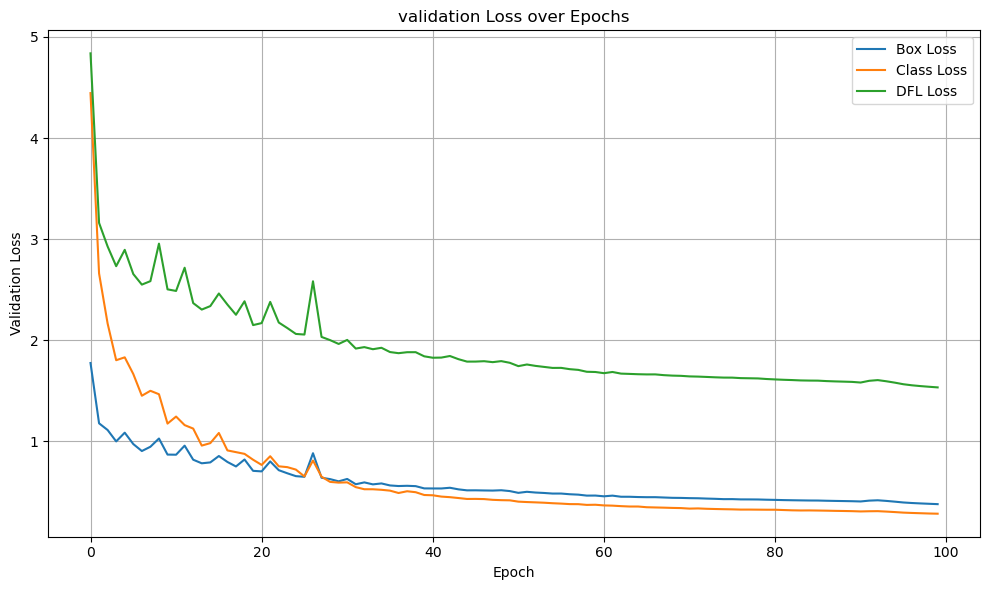

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(df['val/box_loss'], label='Box Loss')
plt.plot(df['val/cls_loss'], label='Class Loss')
plt.plot(df['val/dfl_loss'], label='DFL Loss')

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observation:
- All losses decrease over time which is a strong indicator that your model is learning and generalizing, not just memorizing the training set.
- The validation losses track closely with training losses which is a sign of no overfitting.

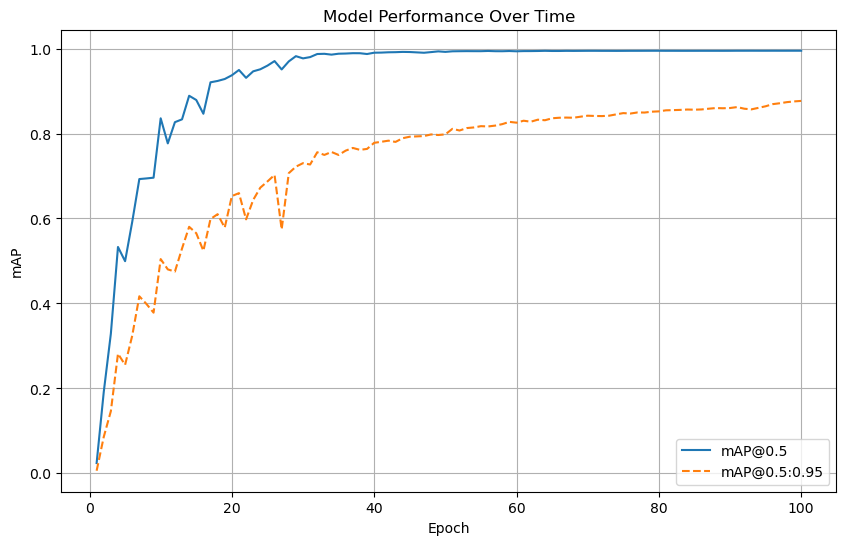

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Model Performance Over Time')
plt.legend()
plt.grid(True)
plt.show()


mAP - mean average precision which is a measure of how well your model Detects objects (correctly draws bounding boxes) and Classifies those objects (assigns the right label)

mAP@0.5 - measures if the object was found and labeled correctly

mAP@0.5:0.95 - measures how precise are the box placements

### Observation:
- The steep incline in both mAP@0.5 and mAP@0.5:0.95 indicates the model is learning rather quickly 
- The gradual convergence towards 1.0 indicates that the model may be overfitting to a certain degree
- This overfitting may be a result of training the model on more epochs than necessary 

In [ ]:
model = YOLO("runs/detect/train11/weights/best.pt")
metrics = model.val(data=data_path, split='val', plots=True)


Ultralytics 8.3.151  Python-3.10.16 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
YOLO11s summary (fused): 100 layers, 9,420,153 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 202.369.4 MB/s, size: 50.0 KB)


val: Scanning F:\LSU_Fullstack_AI_Machine_Learning_Course\capstone_project\roboflow_exercise_images\balanced\valid\labels.cache... 2280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2280/2280 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 143/143 [00:23<00:00,  6.19it/s]


                   all       2280       2282      0.996      0.993      0.995      0.895
   barbell biceps curl        120        120      0.997          1      0.995      0.936
           bench press        120        120      0.992      0.993      0.995      0.893
             chest fly        120        120      0.998          1      0.995       0.89
              deadlift        120        120          1      0.903      0.993      0.867
           hammer curl        120        120      0.997          1      0.995      0.916
            hip thrust        120        120      0.997          1      0.995      0.877
   incline bench press        120        120      0.998          1      0.995       0.89
          lat pulldown        120        120      0.981      0.983      0.989      0.888
         lateral raise        120        120      0.994          1      0.995       0.89
         leg extension        120        120      0.995          1      0.995       0.89
            leg raise

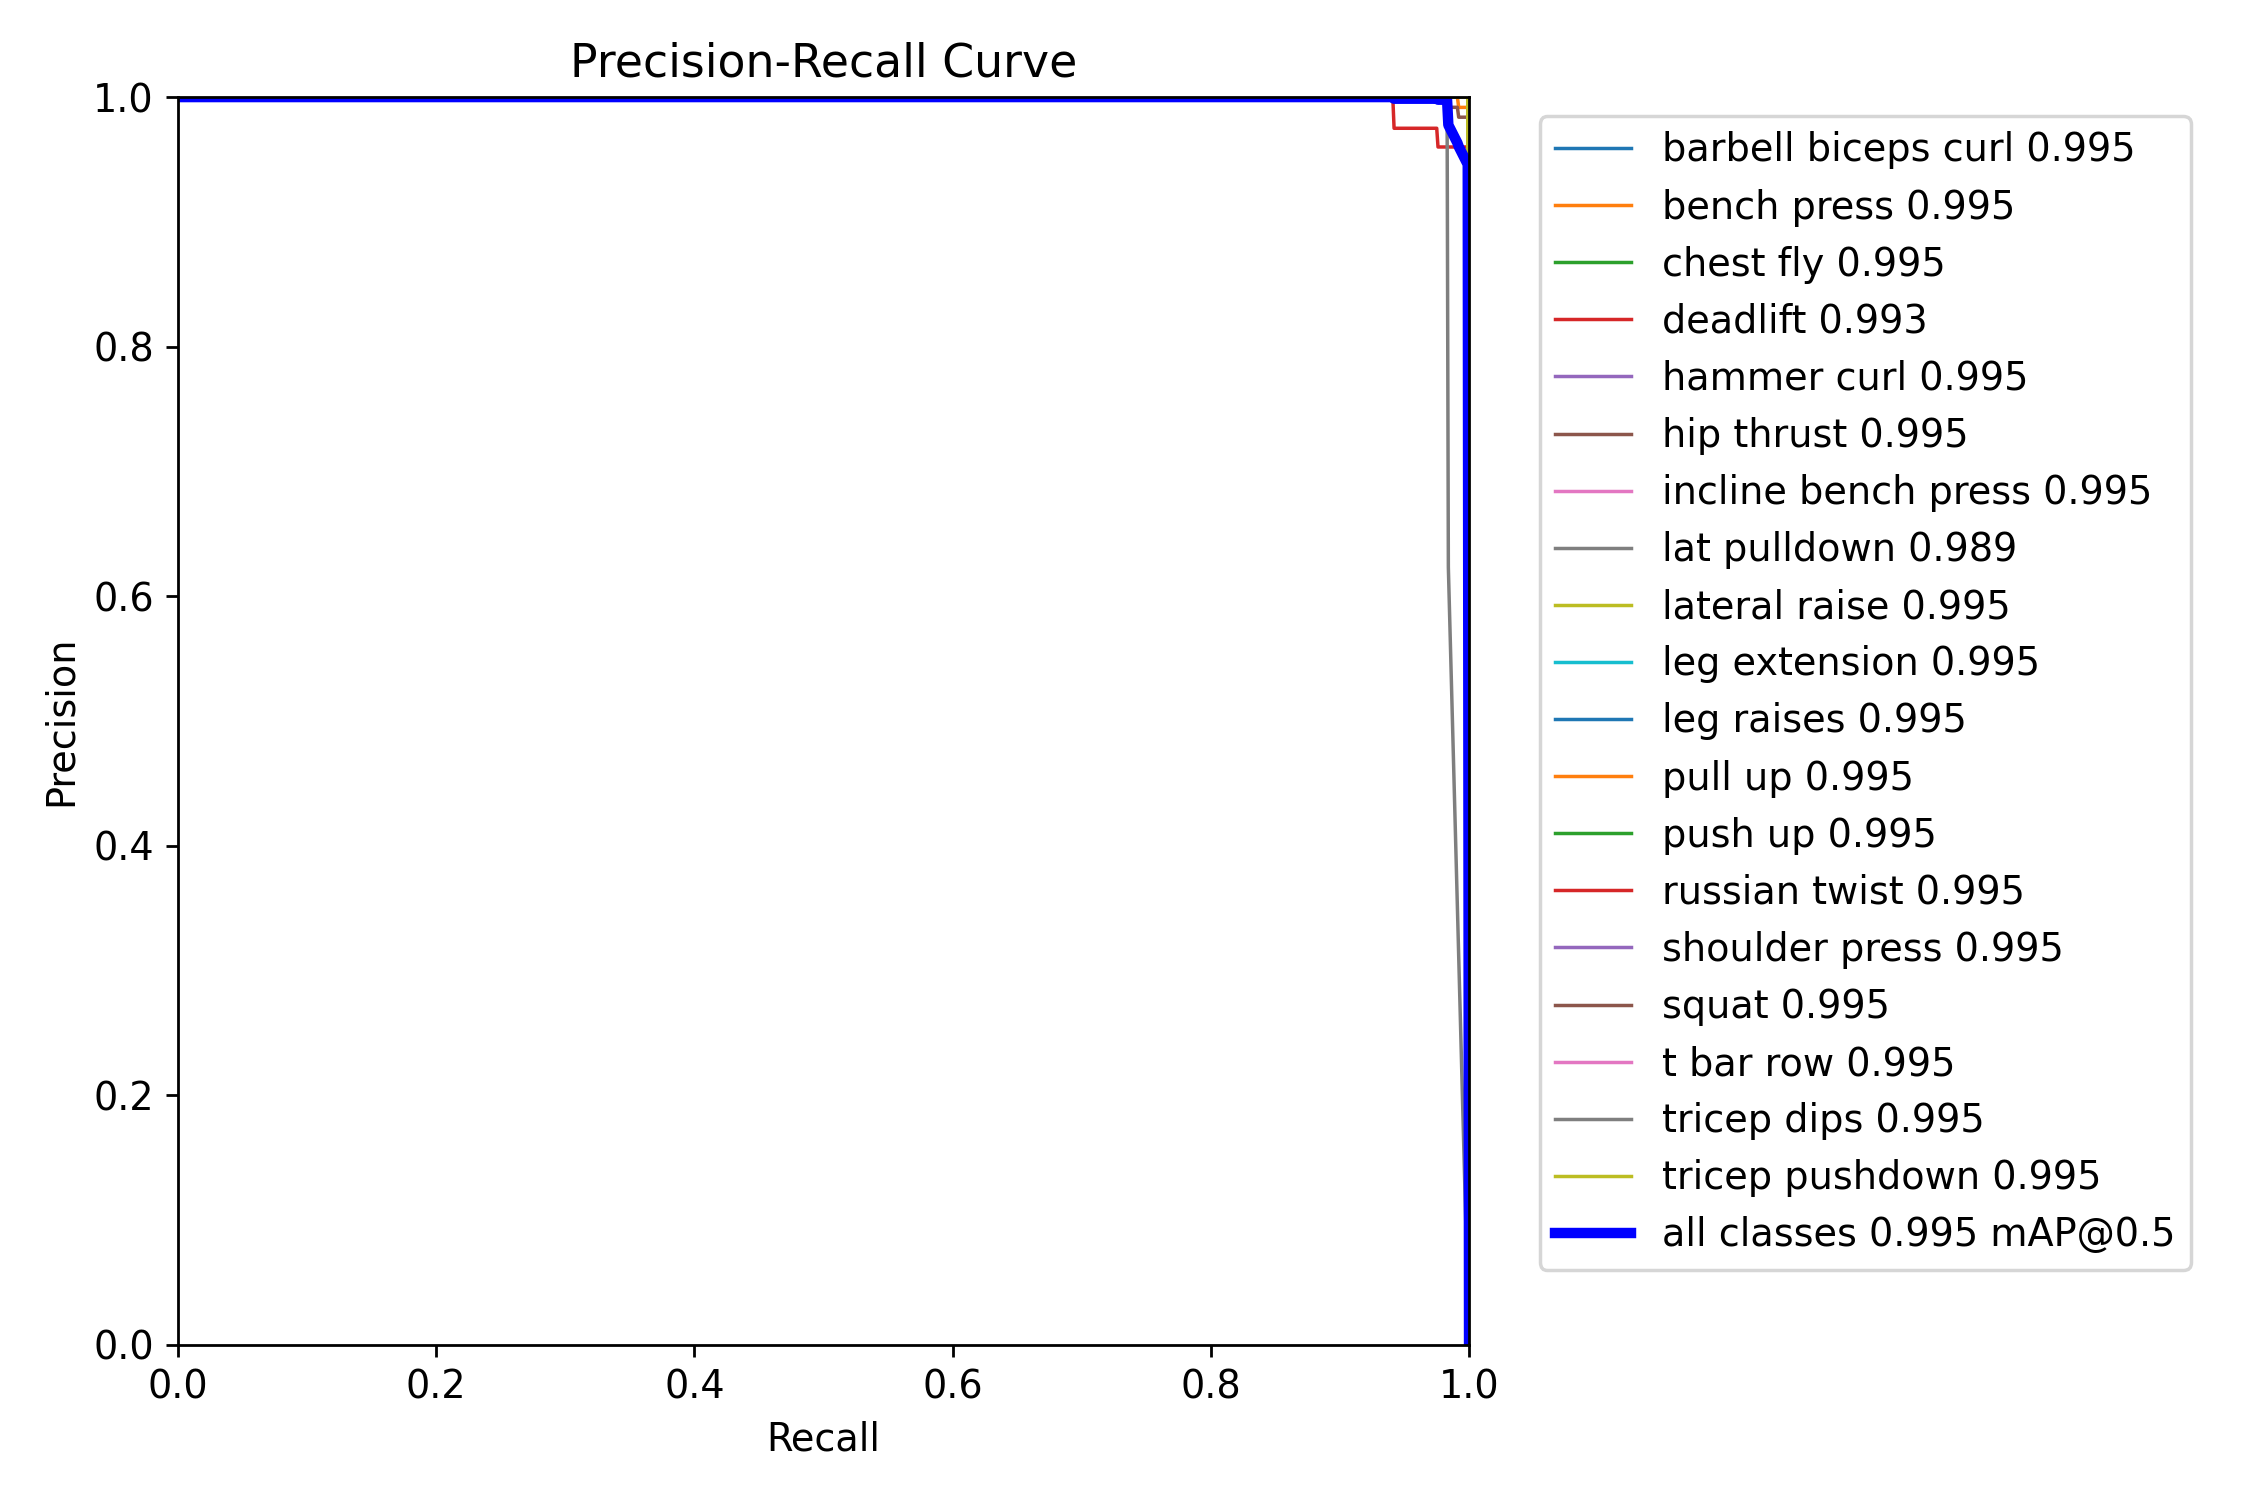

In [ ]:

val_plot_path = "runs/detect/val"  

display(Image(filename=f"{val_plot_path}/PR_curve.png"))




### Observation:
- All individual exercise classes achieve very high average precision scores (AP), ranging from 0.989 to 0.995
- The overall model performance (mAP@0.5 = 0.995) indicates near-perfect classification accuracy
- Most curves hug the top-right corner of the plot, showing high precision maintained across all recall levels
- Lat pulldown has the lowest AP score (0.989) among all exercises, suggesting it might be slightly more challenging to classify or could be confused with  similar pulling movements
- Deadlift also shows a marginally lower score (0.993), which might indicate some confusion with similar compound movements
- All other exercises achieve the same high AP score of 0.995, indicating very consistent performance across different movement types

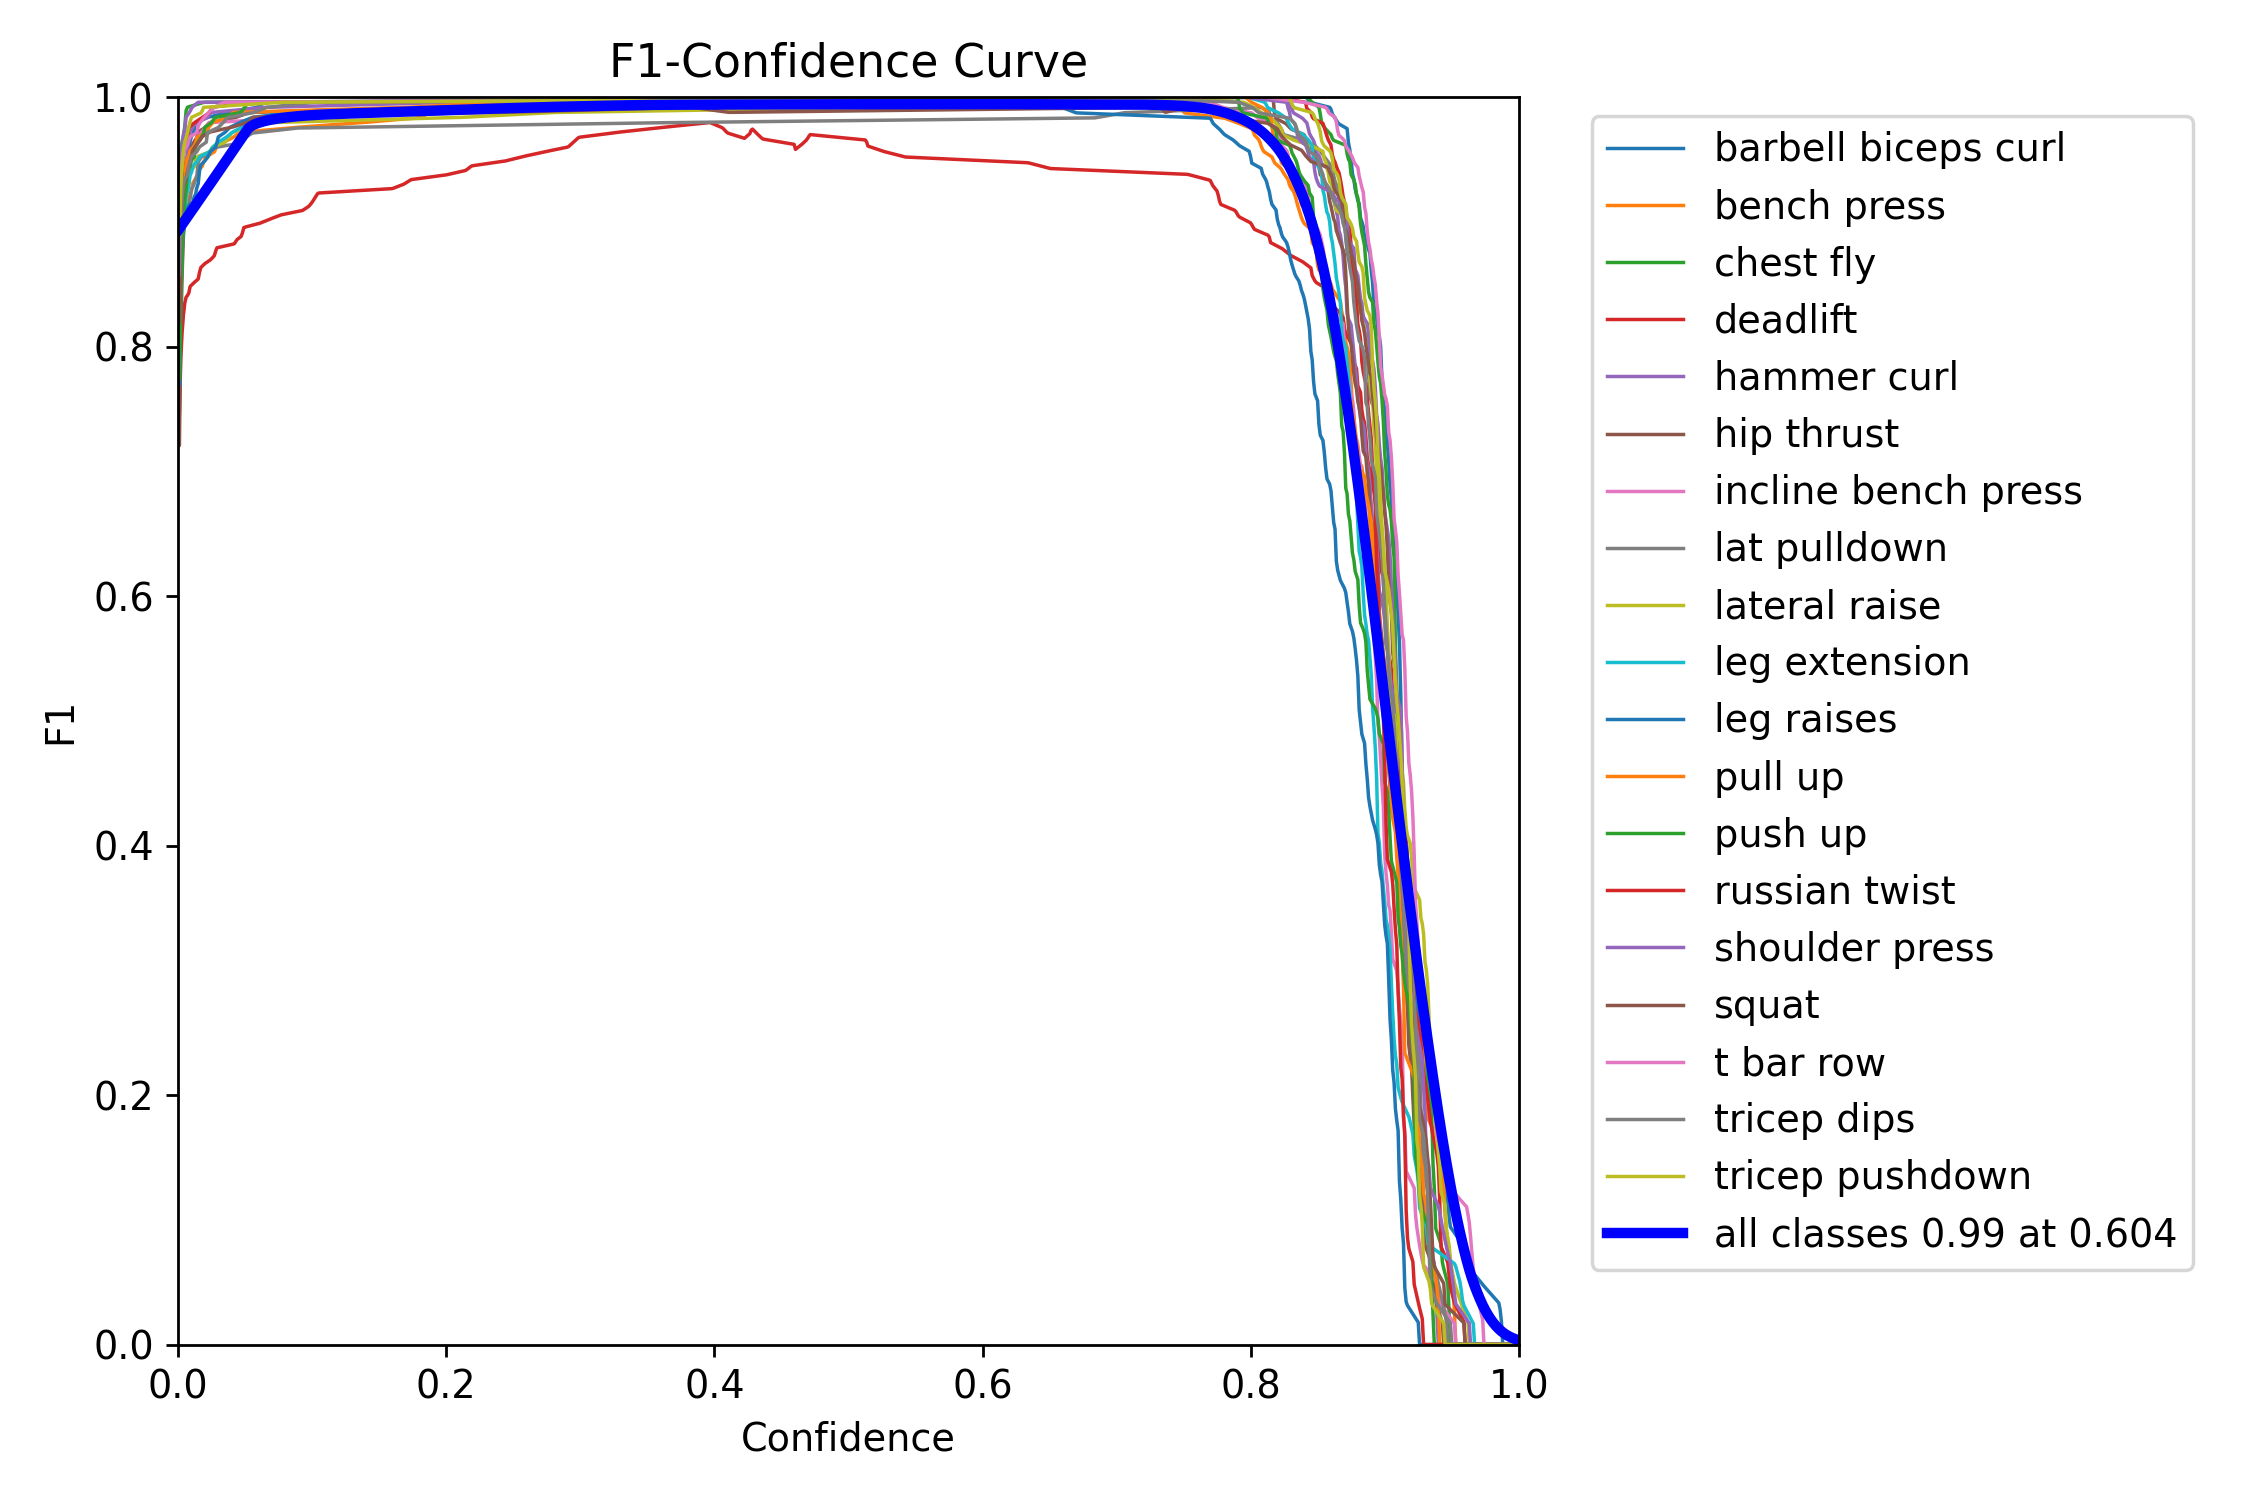

In [ ]:

val_plot_path = "runs/detect/val" 

display(Image(filename=f"{val_plot_path}/F1_curve.png"))

### Observation:
- The overall model achieves an F1 score of 0.99 at a confidence threshold of 0.604, which is quite reasonable - not too high that it rejects many predictions, but high enough to maintain quality.
- Most classes maintain F1 scores near 1.0 across a wide range of confidence thresholds (roughly 0.1 to 0.9)
- Deadlift (red line) shows notably different behavior - it starts lower (~0.85) at low confidence and gradually improves to peak around 0.95-0.97, suggesting this exercise is more challenging for the model to classify with high confidence
- All other exercises show remarkably stable performance with F1 scores consistently above 0.95